In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from cinplaAnalysis.utils import *

%matplotlib ipympl

In [2]:
from cinplaAnalysis.icsd import StandardCSD, DeltaiCSD, StepiCSD

In [23]:
def plotFig(ax,csd,breaks=None,absmax=None,timeLimited=False,plotCB=False,xlabels=False,title=None):

    if breaks is not None:
        for b in breaks:
            ax.plot([0,3000],[b,b],c='k')

    if absmax is None:
        absmax = np.max(np.abs(csd))

    rms = np.mean(np.sqrt(csd**2))
    
    im = ax.imshow(np.array(csd)/rms, origin='lower',cmap='bwr_r',vmin=-10,vmax=10)#, vmin =-absmax,vmax=absmax, cmap='bwr_r')
    ax.axis(ax.axis('tight'))

    if plotCB:
        cb = plt.colorbar(im, ax=ax)
        cb.formatter.set_powerlimits((0,0))


    # ax.set_yticklabels([])

    # if xlabels:
    #     ax.set_xticks([2000,2050],labels=['0','50'])
    #     # ax.set_xlabel('Time (ms)')
    # else:
    #     ax.set_xticklabels([])

    if timeLimited:
        ax.set_xlim([50,100])
    else:
        ax.set_xlim([2000,2050])

    if title:
        plt.title(title)

    plt.tight_layout()

In [10]:
highRes = np.load('../highRes/total_1.npy')
lfpIdx = np.arange(101) # Indices in the output file for LFP electrodes
totalLFPHighRes = highRes[:,lfpIdx]
totalLFPLowRes = highRes[:,0:totalLFPHighRes.shape[1]:2]
totalLFPVeryLowRes = totalLFPLowRes[:,0:totalLFPLowRes.shape[1]:2]

diams = [500]

icsds = []
icsds_low = []

for diam in diams:

    diam *= 1e-6* pq.m                              # [m]
    sigma = 0.376 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
    sigma_top = 0.376 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]
    
    # Input dictionaries for each method

    step_input_verylow = {
        'lfp' : totalLFPVeryLowRes.T * 1E-3 * pq.V,   # [mV] -> [V],
        'coord_electrode' : 80 * np.arange(0,26) * 1e-6 * pq.m,
        'sigma' : sigma
    }

    icsd_verylow = StandardCSD(**step_input_verylow)


In [34]:
testData = np.load('total.npy')

In [35]:
testData.shape

(3000, 24)

In [11]:
icsd_verylow.get_csd().shape

(26, 3000)

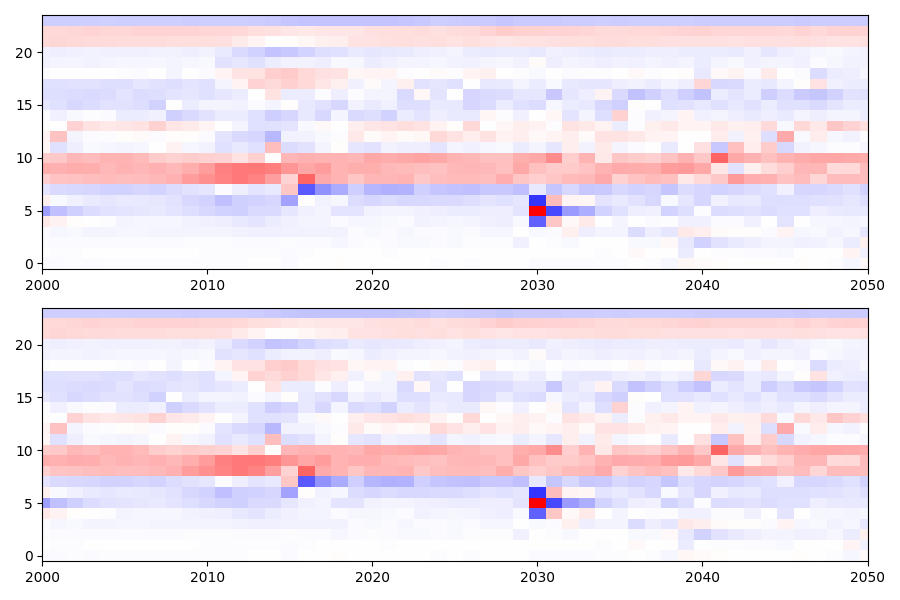

In [37]:
fig, axes = plt.subplots(2,1,figsize=(9,6))

plotFig(axes[0],icsd_verylow.get_csd()[1:-1],xlabels=True)
plotFig(axes[1],-testData.T,xlabels=True)

In [40]:
correlations2 = []
for i in np.arange(2000,2050):
    correlations2.append(np.corrcoef(icsd_verylow.get_csd()[1:-1,i],-testData.T[:,i])[0,1])

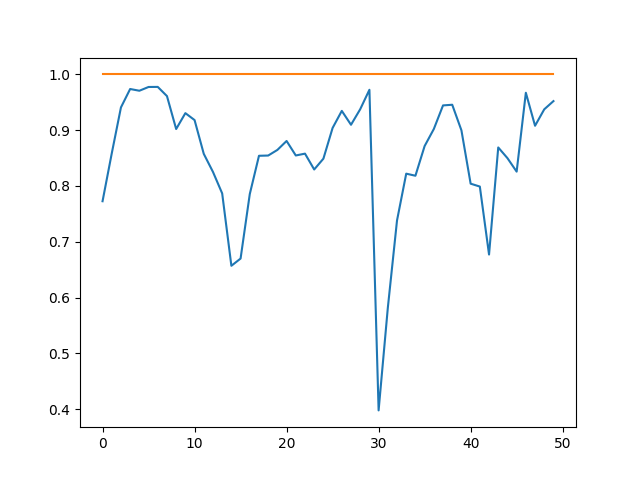

In [42]:
plt.figure()
plt.plot(correlations)
plt.plot(correlations2)
# plt.ylim([0,1])